In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [3]:
#%% Pick the filename and path
files = [
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5',
#             '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5',
             '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5',
#         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p005/snapshots/snapshots_1e-5_0p005.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2.h5',
#        '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V5/snapshots/snapshots_1e-5_0p02_V5.h5',

         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p01/snapshots/snapshots_1e-7_0p01.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5',
         #'/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_orig.h5'
        ]

filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5'
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5'
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2.h5'
#filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5'

print(filename)
f = h5py.File(filename, 'r')
print('Loaded')
# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'][0,0,0] # Slope angle


# Load variables in physical space
b = f['tasks']['b'] # Perturbation buoyancy
v = f['tasks']['v'] # Along-slope direction
u = f['tasks']['u'] # Along-slope direction

vbfr = f['tasks']['VBFrotated']
vbftot = f['tasks']['VBFr'] # includes cross-slope advection
GSPr = f['tasks']['GSProtated']
SP = f['tasks']['SP']
DISS = f['tasks']['Diss']
VPWP = f['tasks']['GSProtated'][:,:,:]*1e-4/(N**2*np.sin(tht))
UPWP = f['tasks']['UPWP'][:,:,:]

q = f['tasks']['PV']
wq = f['tasks']['wq']    
qm = np.mean(q, axis=1)
Qo = 1e-4*N**2

x = v.dims[1][0][:]    
z = v.dims[2][0][:]
time = v.dims[0][0][:]
vm = np.mean(v, axis=1)
um = np.mean(u, axis=1)
bm = np.mean(b, axis=1)
vz = np.gradient(vm, axis=-1)/np.gradient(z)
uz = np.gradient(np.mean(u, axis=1), axis=-1)/np.gradient(z)
bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
lmix = np.sqrt(np.abs(np.array(VPWP[:,0,:])/1030))/np.array(vz)
N2total = bz + N**2
# Calculate BEk
tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
taux = -1035*1e-4*uz[:,0]
ustar = np.sqrt(np.abs(taux + 1j*tauy)/1035)
S2 = N**2*tht**2/1e-8
Bek = -(tauy/(1030*1e-4)*N**2*np.sin(tht))/(1+S2)
MOdepth = (1+S2)*ustar*1e-4/(0.4*tht*N**2)
nt, nx, nz = b.shape
Htotal = []
htotal = []
for ti in range(0, nt):
        
        #Average the vert buoyancy flux 
        vsmooth = vbfr[ti,0,:]

        qmean = qm[ti,:] #direct calculation of Q
    
        indq = np.where(qmean>0.9*Qo)[0][0] 

        Htotal.append(z[indq]) # pick out H
        # Find where h is (where vert. buoyancy flux is 0)
        inds = np.where(np.logical_and(vsmooth<0, z<=z[indq]))[0]
        if inds.size == 0:
            print('No Ind: ' + filename)
            htotal.append(z[indq])
        else:
            #inds = [inds[-1]]
            inds = [inds[0]]
            htotal.append( z[inds[0]])
            
Htotal = np.array(Htotal)
htotal = np.array(htotal)

MOdepth = 1e-4*ustar*(1+N**2*tht**2/1e-8)/(0.4*N**2*tht)

/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5
Loaded


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


No Ind: /data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5


In [552]:
x = v.dims[1][0][:]    

vx = np.gradient(v, axis=1)/(np.gradient(x)[np.newaxis,:,np.newaxis])
bp = b - bm[:,np.newaxis,:]

zetapbp = np.mean(vx*bp, axis=1)

In [548]:
bp.shape

(1658, 2048, 256)

In [449]:
l = np.sqrt(-np.array(DISS[:,0,:])/(np.array(N2total)**(3/2)))
hd = Htotal[:,np.newaxis]/(1-l/(0.4*Htotal[:,np.newaxis]))
lperl = 0.4*z*(1- z/hd)
ltest = 0.1*(-z + 0.3*Htotal[:, np.newaxis])
#ltest = 1*htotal[:,np.newaxis]*(1-z/Htotal[:,np.newaxis])
#ltest = (0.3*MOdepth)[:,np.newaxis]*(1 - z/Htotal[:,np.newaxis])
#ltest = 3*(1-z/Htotal[:,np.newaxis])
S2 = (N**2*tht**2/1e-8)
lalt = ustar[:,np.newaxis]*np.sqrt(tht*(1+S2)**2)/np.sqrt(S2**3*N * 1e-4)*np.sqrt(1-z[np.newaxis,:]/Htotal[:,np.newaxis])
lalt = np.sqrt(ustar[:,np.newaxis]**2 *N**2 *tht * (1-z[np.newaxis,:]/Htotal[:,np.newaxis])/(1e-4*(1+S2)*N2total**(3/2)))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


In [450]:
lmix = ustar[:,np.newaxis]/np.abs(np.array(vz))
lnum = np.sqrt(np.abs(np.array(VPWP[:,0,:])))/np.abs(np.array(vz))
#lnum = np.sqrt(np.abs(np.array(VPWP[:,0,:])))/(-bz*tht/(1e-4))
lmix.shape

lk = (-1e-12/np.array(DISS[:,0,:]))**(1/4)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


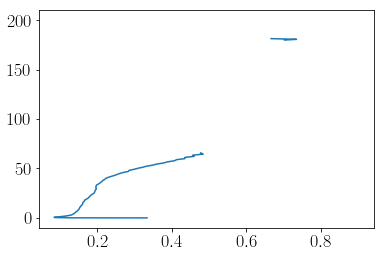

In [575]:
plt.plot(np.mean(lk[trange,:], axis=0), z, label='$l_k$')


Text(0.5,0,'$l$ [m]')

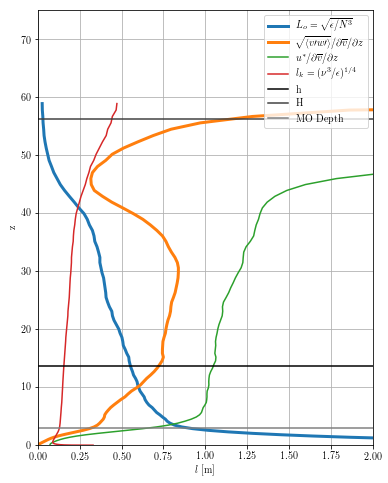

In [451]:
ts = 600
#ts = 420
tr = 18*4
trange = range(ts, ts+tr)

plt.figure(figsize=(6,8))
#plt.plot(np.mean(qm[trange,:], axis=0), z)
plt.plot(np.mean(l[trange,:], axis=0), z, linewidth=3, label='$L_o = \sqrt{\epsilon/N^3}$')
plt.plot(np.mean(lnum[trange,:], axis=0), z,linewidth=3, label=r'$\sqrt{\langle v\prime w\prime\rangle}/\partial \overline{v}/\partial z$')

plt.plot(np.mean(lmix[trange,:], axis=0), z, label='$u^*/\partial \overline{v}/\partial z$')
plt.plot(np.mean(lk[trange,:], axis=0), z, label=r'$l_k = (\nu^3/\epsilon)^{1/4}$')

#plt.plot(np.mean(lperl[trange,:], axis=0), z, linestyle='--')
#plt.plot(np.mean(ltest[trange,:], axis=0), z, linestyle='--', label=r'$\gamma(\beta - z/H)$')
#plt.plot(np.mean(lalt[trange,:], axis=0), z, linestyle='--', label='$L_o$ Scale')

plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
#plt.plot(np.mean(ustar[trange]*Htotal[trange]/0.1)*(1-z/np.mean(Htotal[trange])), z)
#Hr = np.mean(Htotal[trange])# - MOdepth[trange])
#plt.plot(np.mean(ustar[trange]/(N**2*tht*1e4/(1+S2)))*(1-(z-np.mean(MOdepth[trange]))/Hr), z)

#plt.axvline(np.mean(ustar[trange]/(N**2*tht*1e4/(1+S2))), color='g')
#plt.axvline(1.6*np.mean(htotal[trange]/(1+htotal[trange]/(0.4*MOdepth[trange]))), color='r')
#plt.axvline(np.mean(np.array(MOdepth/Htotal)[trange]*6.5 + htotal[trange]/Htotal[trange]), color='y')
#plt.plot(0.4*z, z)
plt.xlim(0,2)
plt.ylim(0, 75)
plt.legend()
plt.grid()
plt.ylabel('z')
plt.xlabel('$l$ [m]')

Text(0.5,0,'$l$ [m]')

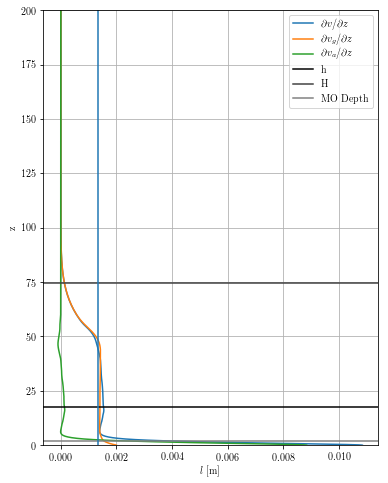

In [453]:
ts = 24*2*30
#ts = 420
tr = 18*4
trange = range(ts, ts+tr)

plt.figure(figsize=(6,8))
plt.plot(np.mean(vz[trange,:], axis=0), z, label='$\partial v/\partial z$')
plt.plot(np.mean(-bz[trange,:]*tht/(1e-4), axis=0), z, label='$\partial v_g/\partial z$')
plt.plot(np.mean(vz[trange, :] + bz[trange,:]*tht/(1e-4), axis=0), z, label='$\partial v_a/\partial z$')

#plt.plot(0.4*z, z)
#plt.xlim(0,2)
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
plt.axvline(0.1/np.mean(Htotal[trange]))
#plt.axvline(np.mean(ustar[trange]/(0.4*MOdepth[trange])))
plt.ylim(0, 200)
#plt.xlim(-5e-3, 5e-3)
plt.legend()
plt.grid()
plt.ylabel('z')
plt.xlabel('$l$ [m]')

Text(0.5,0,'[m/s]')

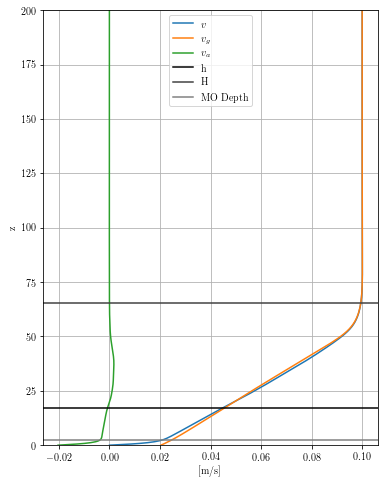

In [56]:
ts = 24*2*20
#ts = 420
tr = 18*4
trange = range(ts, ts+tr)
vg = integrate.cumtrapz(-bz*tht/(1e-4), x=z, axis=-1, initial =0)
vg = vg + (0.1-vg[:,-1])[:,np.newaxis]
plt.figure(figsize=(6,8))
plt.plot(np.mean(vm[trange,:]+0.1, axis=0), z, label='$v$')
plt.plot(np.mean(vg[trange,:], axis=0), z, label=' $v_g$')
plt.plot(np.mean(vm[trange, :] - vg[trange,:]+0.1, axis=0), z, label='$v_a$')

#plt.plot(0.4*z, z)
#plt.xlim(0,2)
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')

#plt.axvline(np.mean(ustar[trange]/(0.4*MOdepth[trange])))
plt.ylim(0, 200)
#plt.xlim(-1e-1, 1e-1)
plt.legend()
plt.grid()
plt.ylabel('z')
plt.xlabel('[m/s]')

In [52]:
0.1-vg[:,-1]

array([0.09999885, 0.0989621 , 0.09832165, ..., 0.00672698, 0.00672808,
       0.00673251])

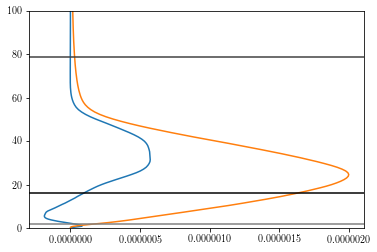

In [20]:
ts = 48*35
#ts = 420
tr = 18*4
trange = range(ts, ts+tr)
plt.plot(np.mean(-VPWP[trange,0,:], axis=0), z)
plt.plot(np.mean(-UPWP[trange,0,:], axis=0), z)
#plt.plot(-np.mean(np.array(DISS[trange,0,:])/(np.array(N2total[trange,:])**(3/2)), axis=0), z)

plt.ylim(0, 100)
#plt.xlim(-2, 4)
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
#plt.axvline(0.1**2*tht/S2)
#plt.axvline(np.mean(Bek[trange])*(1+S2)/(N**2*tht))

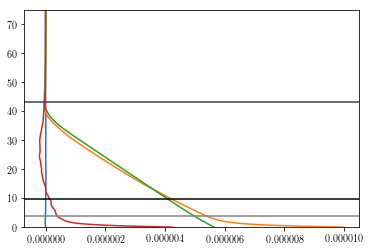

In [62]:
#Across-slope momentum budget
ts = 48*5
#ts = 420
tr = 18*4
trange = range(ts, ts+tr)
FLUX = -np.gradient(np.mean(UPWP[trange,0,:], axis=0))/np.gradient(z)
FLUXD = 1e-4*np.gradient(np.mean(uz[trange,:], axis=0))/np.gradient(z)
ROC = np.gradient(um, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
ROC = np.mean(ROC[trange,:], axis=0)
plt.plot(ROC, z, label='ROC')
plt.plot(-1e-4*np.mean(vm[trange,:], axis=0), z, label='COR')
plt.plot(tht*np.mean(bm[trange,:], axis=0), z, label='BUOY')
plt.plot(FLUX+FLUXD,z ,label='FLUX')
#plt.xlim(-1e-4, 1e-4)
plt.ylim(0, 75)

plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')

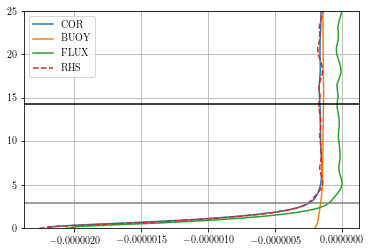

In [101]:
#Across-slope shear budget
ts = 48*15
#ts = 420
tr = 18*4
trange = range(ts, ts+tr)
FLUX = -np.gradient(np.mean(UPWP[trange,0,:], axis=0))/np.gradient(z)
FLUX = np.gradient(FLUX)/np.gradient(z)
FLUXD = 1e-4*np.gradient(np.mean(uz[trange,:], axis=0))/np.gradient(z)
FLUXD = np.gradient(FLUXD)/np.gradient(z)

ROC = np.gradient(uz, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
ROC = np.mean(ROC[trange,:], axis=0)
#plt.plot(ROC, z, label='ROC')
plt.plot(-1e-4*np.mean(vz[trange,:], axis=0), z, label='COR')
plt.plot(tht*np.mean(bz[trange,:], axis=0), z, label='BUOY')
plt.plot(FLUX+FLUXD,z ,label='FLUX')
plt.plot(FLUX+FLUXD+tht*np.mean(bz[trange,:], axis=0), z, label='RHS', linestyle='--')
#plt.xlim(-1e-4, 1e-4)
plt.ylim(0, 25)

plt.legend()
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
plt.grid()

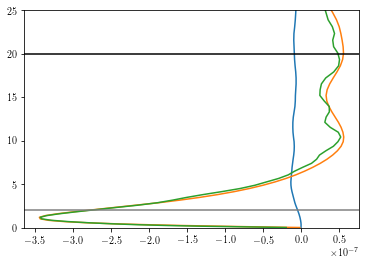

In [107]:
#Along-slope momentum budget
ts = 48*30
#ts = 420
tr = 18*4
trange = range(ts, ts+tr)
ROC = np.gradient(vm, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
ROC = np.mean(ROC[trange,:], axis=0)
FLUX = -np.gradient(np.mean(VPWP[trange,0,:], axis=0))/np.gradient(z)
FLUXD = 1e-4*np.gradient(np.mean(vz[trange,:], axis=0))/np.gradient(z)
plt.plot(ROC, z, label='ROC')

plt.plot(1e-4*np.mean(um[trange,:], axis=0), z, label='COR')
plt.plot(FLUX+FLUXD,z ,label='FLUX')
#plt.xlim(-1e-4, 1e-4)
plt.ylim(0, 25)
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')

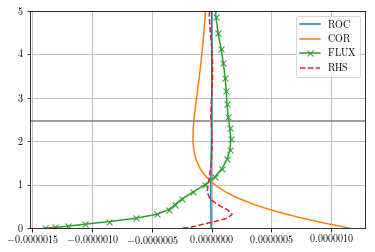

In [106]:
#Along-slope shear budget
ts = 48*20
#ts = 420
tr = 48*4
trange = range(ts, ts+tr)
FLUX = -np.gradient(np.mean(VPWP[trange,0,:], axis=0))/np.gradient(z)
FLUX = np.gradient(FLUX)/np.gradient(z)
FLUXD = 1e-4*np.gradient(np.mean(vz[trange,:], axis=0))/np.gradient(z)
FLUXD = np.gradient(FLUXD)/np.gradient(z)

ROC = np.gradient(vz, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
ROC = np.mean(ROC[trange,:], axis=0)
plt.plot(ROC, z, label='ROC')
plt.plot(-1e-4*np.mean(uz[trange,:], axis=0), z, label='COR')
plt.plot(FLUX+FLUXD,z ,label='FLUX', marker='x')
plt.plot(FLUX+FLUXD-1e-4*np.mean(uz[trange,:], axis=0), z, label='RHS', linestyle='--')
#plt.xlim(-1e-8, 1e-8)
plt.ylim(0, 5)

plt.legend()
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
plt.grid()

(1920, 256)

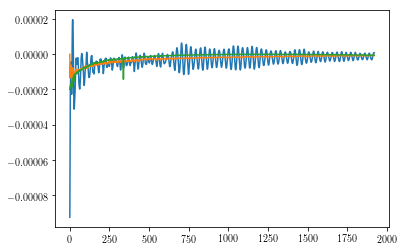

In [67]:
V = integrate.trapz(vm, axis=-1, x=z)
plt.plot((1+S2)/S2*np.gradient(V)/np.gradient(time))
plt.plot(tauy/1035)
cd = 2e-3
Vi = 0.1
tautheory = -1035*cd*(Vi - Htotal*N**2*tht/(1e-4*(1+N**2*tht**2/1e-8)))**2
plt.plot(tautheory/1035)

(-5e-09, 5e-09)

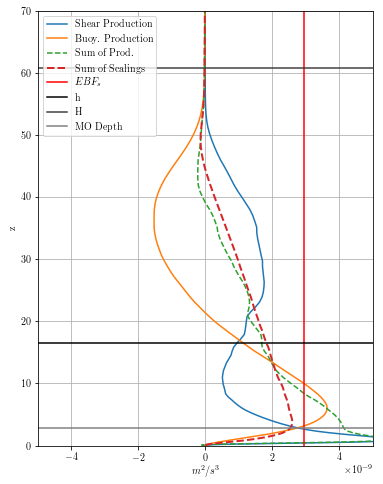

In [10]:
ts = 48*15
#ts = 420
tr = 18*2*4
trange = range(ts, ts+tr)
plt.figure(figsize=(6,8))
plt.plot(-np.mean(SP[trange,0,:], axis=0), z, label='Shear Production')
#plt.plot(-np.mean(GSPr[trange,0,:]/(1+S2), axis=0), z)

plt.plot(np.mean(vbfr[trange,0,:], axis=0), z, label='Buoy. Production')
plt.plot(np.mean(vbftot[trange,0,:]-SP[trange,0,:], axis=0), z, linestyle='--', label='Sum of Prod.')

plt.plot(np.mean((vbfr[trange,0,:]-GSPr[trange,0,:])/(1+S2), axis=0), z, linestyle='--',linewidth=2, label='Sum of Scalings')


plt.grid()
plt.axvline(np.mean(Bek[trange]), color='r', label='$EBF_s$')
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
plt.legend()
plt.ylim(0, 70)
plt.ylabel('z')
plt.xlabel('$m^2/s^3$')
xl = 0.5e-8
#xl = 2e-8
plt.xlim(-xl, xl)

In [787]:
vbfr.shape

(2160, 1, 256)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(0, 1)

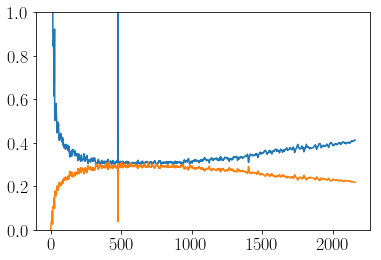

In [629]:
plt.plot(300*1e-4/ustar/Htotal) # Logarithmic region ~ z^+ O(300)
plt.plot(3*1e-4*Htotal*ustar/1e-4)
#plt.plot(htotal/Htotal)
plt.ylim(0, 1)

In [630]:
u.shape

(2160, 1024, 256)

In [665]:
um = np.mean(u, axis=1)
UT = integrate.cumtrapz(um, axis=-1, x=z)
#vm = np.mean(v, axis=1)
#VT = integrate.cumtrapz(vm, axis=-1, x=z)

In [634]:
UT.shape

(2160, 255)

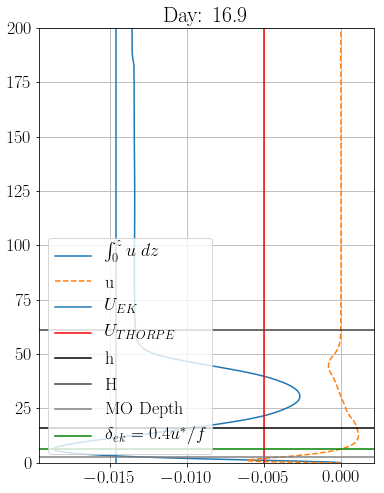

In [760]:
ts = 48*15
#ts = 420
tr = 18*2*5
trange = range(ts, ts+tr)
plt.figure(figsize=(6,8))

plt.plot(np.mean(UT[trange,:], axis=0), z[1:], label=r'$\int_0^z u\;dz$')
plt.plot(np.mean(um[trange,:], axis=0), z[:], label=r'u', linestyle='--')

#plt.plot(np.mean(np.gradient(UT[trange,:], axis=0)/np.gradient(time[trange,np.newaxis], axis=0), axis=0)/1e-4, z[1:])
#plt.plot(np.mean(um[trange,:], axis=0), z)
plt.axvline(np.mean(tauy[trange]/(1035*1e-4*(1+S2))), label=r'$U_{EK}$')
plt.axvline(-1e-4/tht, color='r', label=r'$U_{THORPE}$')
#plt.axvline(-1e-4*np.mean(N2total[trange,0])/(N**2*tht), color='y', label=r'$U_{THORPE}$')

plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
#plt.axhline(1e-4/np.mean(ustar[trange])*260, color='r')
tm = np.mean(time[trange])/86400
plt.title(f'Day: {tm:1.1f}')

plt.axhline(0.4*np.mean(ustar[trange])/1e-4, color='g', label=r'$\delta_{ek} = 0.4 u^*/f$')
plt.ylim(0, 200)
plt.legend()
plt.grid()

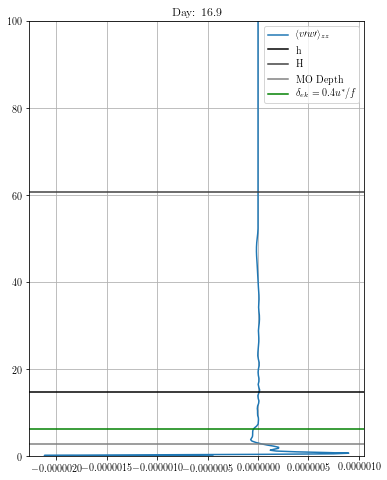

In [454]:
ts = 48*15
#ts = 420
tr = 18*2*5
trange = range(ts, ts+tr)
plt.figure(figsize=(6,8))

#plt.plot(np.mean(N2total[trange,:], axis=0), z[:], label=r'$N^2$')
#plt.plot(np.mean(wq[trange,0,:], axis=0), z[:], label=r'$\langle w\prime q\prime \rangle$')
vpwp_z = np.gradient(VPWP, axis=-1)/np.gradient(z) - 0*1e-4*vz[:,np.newaxis,:]
vpwp_zz = np.gradient(vpwp_z, axis=-1)/np.gradient(z)
plt.plot(np.mean(vpwp_zz[trange,0,:], axis=0), z[:], label=r'$\langle v\prime w\prime \rangle_{zz}$')
#plt.plot(N2total[trange[-1],:] - N2total[trange[0],:], z[:])
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
#plt.axhline(1e-4/np.mean(ustar[trange])*260, color='r')
tm = np.mean(time[trange])/86400
plt.title(f'Day: {tm:1.1f}')

plt.axhline(0.4*np.mean(ustar[trange])/1e-4, color='g', label=r'$\delta_{ek} = 0.4 u^*/f$')
plt.ylim(0, 100)
plt.legend()
plt.grid()

(-1e-12, 1e-14)

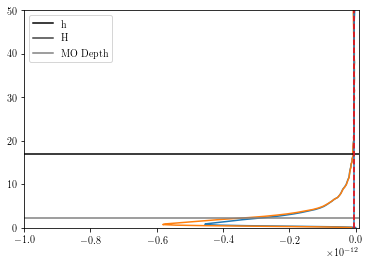

In [573]:
ts = 48*25
#ts = 420
tr = 18*2*5
trange = range(ts, ts+tr)
fric =  N**2*tht*1e-4*np.gradient(np.mean(vz[trange,:], axis=0))/np.gradient(z)
dia = -1e-4*1e-4*np.gradient(np.mean(bz[trange,:], axis=0))/np.gradient(z)
plt.plot(np.mean(wq[trange,0,:], axis=0), z)
plt.plot(np.mean(wq[trange,0,:], axis=0)+fric+dia, z)
plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')
plt.axvline(-np.mean(Bek[trange])*1e-4*(1+N**2*tht**2/1e-8)/np.mean(Htotal[trange]))
plt.axvline(1e-4*np.mean(-N**2*tht*vz[trange,0])/np.mean(Htotal[trange]), color='r', linestyle='--')
#plt.axvline(-np.mean(tauy[trange]/1030/1e-4))
plt.legend()
plt.ylim(0, 50)
plt.xlim(-1e-12, 1e-14)

(0, 90)

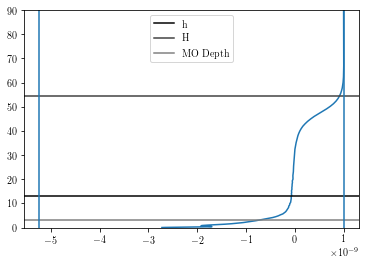

In [592]:
ts = 48*10
#ts = 420
tr = 18*2*5
trange = range(ts, ts+tr)

plt.plot(np.mean(qm[trange,:], axis=0), z)

plt.axhline(np.mean(htotal[trange]), color='k', label='h')
plt.axhline(np.mean(Htotal[trange]), color = '0.25', label ='H')
plt.axhline(np.mean(MOdepth[trange]), color = '0.5', label='MO Depth')

#plt.axvline(-np.mean(tauy[trange]/1030/1e-4))
plt.axvline(1e-4*N**2)
plt.axvline(-N**2*tht*np.mean(vz[trange,0]))
plt.legend()
plt.ylim(0, 90)
#plt.xlim(-1e-12, 1e-14)

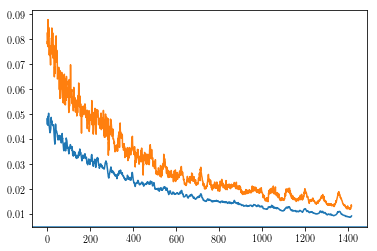

In [594]:
t1 = 48*5

plt.plot(vz[t1:,0])

#plt.plot(np.max(vz[t1:,0])-integrate.cumtrapz(1e-4*(1+N**2*tht**2/1e-8)*Bek[t1:]/(N**2*tht)/(0.35*Htotal[t1:]**2), x=time[t1:]), linestyle='--')
#plt.plot(np.gradient(vz[:,0])/np.gradient(time))

#plt.plot(np.max(vz[t1:,0])-integrate.cumtrapz(1e-4*(1+N**2*tht**2/1e-8)*Bek[t1:]/(N**2*tht*(0.19*Htotal[t1:])**2), x=time[t1:]))
vzz = np.gradient(vz[t1:,:], axis=-1)/np.gradient(z)
vzzz = np.gradient(vzz, axis=-1)/np.gradient(z)
bzz = np.gradient(bz[t1:,:], axis=-1)/np.gradient(z)
bzzz = np.gradient(bzz, axis=-1)/np.gradient(z)
wqz = np.gradient(wq[t1:,0,:], axis=-1)/np.gradient(z)
VPWPz = np.gradient(VPWP[t1:,0,:], axis=-1)/np.gradient(z)
VPWPzz = np.gradient(VPWPz, axis=-1)/np.gradient(z)
zetapbpz = np.gradient(zetapbp[t1:,:], axis=-1)/np.gradient(z)
#plt.plot(np.max(vz[t1:,0])+1*integrate.cumtrapz(0*wqz[:,0]/(N**2*tht)-VPWPzz[:,0]+1e-4*1e-4*bzzz[:,0]/(N**2*tht)-1e-4*vzzz[:,0], x=time[t1:]))
plt.plot(-(qm[t1:,0]-0*zetapbpz[:,0] - N**2*tht*vz[t1:,0])/(N**2*tht))
#plt.plot(np.max(vz[:,0])-0e-4*bz[:,0]/(N**2*tht)-1/(N**2*tht)*integrate.cumtrapz(np.gradient(wq[:,0,:], axis=-1)/(np.gradient(z)), axis=0, x=time, initial=0)[:,0])
#plt.ylim(-1e-6, 1e-6)
plt.axhline(1e-4/tht)

(0, 0.1)

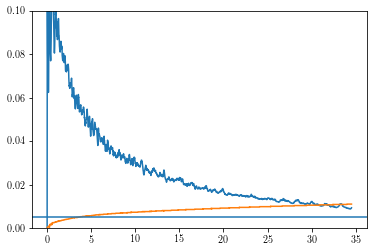

In [660]:
isoslope = tht/(N**2*tht**2/1e-8)
isoslope
0.1**2*isoslope
#plt.plot(time/86400, np.max(np.abs(VPWP[:,0,:]), axis=-1))
plt.plot(time/86400, vz[:,0])
#plt.plot(time/86400, 0.3*0.1**2*isoslope/Htotal + 0*VPWP[:,0,0])
maxvel = N**2*tht*Htotal/(1e-4*(1+N**2*tht**2/1e-8))
plt.plot(time/86400, maxvel/(10))
#plt.scatter(vz[:,0], ((Htotal)*1e-4/isoslope), c=time)
plt.ylim(0, 1e-1)

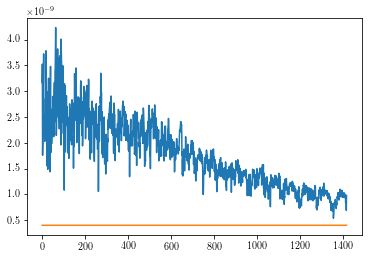

In [569]:
plt.plot(zetapbpz[:,0])
#plt.plot(vz[t1:, 0])
plt.plot(1e-4*(N**2*tht/1e-4)**2+ 0*zetapbpz[:,0])

(1658, 1, 256)

(0.0001, 0.02)

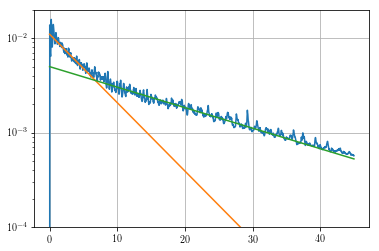

In [81]:
plt.semilogy(time/86400, -tauy)
#plt.plot(time/86400, 1030*3e-3*(0.1 - np.array(Htotal)*N**2*tht/(1e-4*(1+S2)))**2)
plt.semilogy(time/86400, 1.1e-2*np.exp(-time/86400/6))
plt.semilogy(time/86400, 0.5e-2*np.exp(-time/86400/20))

plt.grid()
plt.ylim(1e-4, 2e-2)

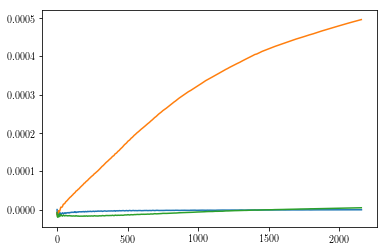

In [144]:
V = integrate.trapz(vm, axis=-1, x=z)
B = integrate.trapz(bm, axis=-1, x=z)
plt.plot(tauy/1030)
Vt = np.gradient(V)/np.gradient(time)
Vtt = np.gradient(Vt)/np.gradient(time)

plt.plot(-integrate.cumtrapz(Vtt+1e-8*V + 1e-4*B*tht - 0*1e-4*taux/1030, x=time))
plt.plot(-integrate.cumtrapz(Vtt+1e-8*V + 1e-4*B*tht + 1e-4*taux/1030, x=time))
#plt.ylim(-1e-9, 1e-9)

In [91]:
bm = np.mean(b, axis=1)

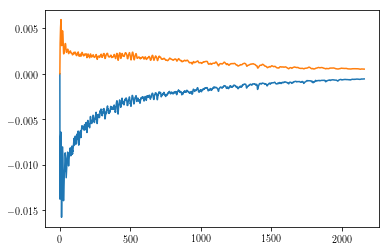

In [127]:
plt.plot(tauy)
plt.plot(taux)

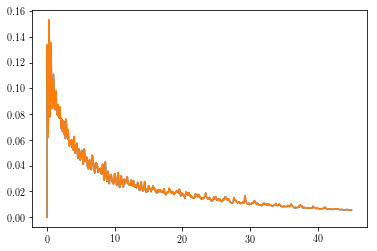

In [317]:
plt.plot(time/86400, np.gradient(vz[:,0])
plt.plot(time/86400, (1+N**2*tht**2/1e-8)*Bek/(N**2*tht))
#plt.plot(time/86400,-N**2*tht/1e-4 + 0*time)
#plt.plot(time[2:]/86400,bz[2:,0]*tht/1e-4)
#plt.plot(time[10:]/86400, 0.1/Htotal[10:])
#plt.plot(time/86400,(np.gradient(uz, axis=-1)/np.gradient(z))[:,0])
#plt.plot(time/86400,(np.gradient(VPWP[:,0,:], axis=-1)/np.gradient(z))[:,0]/1e-4)

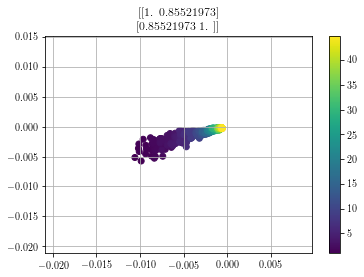

In [313]:
#plt.scatter(tauy, -(np.gradient(uz, axis=-1)/np.gradient(z))[:,0])
t1 = 24*2*1
mask = htotal[t1:]>1e-1

xvar = tauy[t1:]
yvar = N**2*tht/(1e-4*(1+S2))/Htotal[t1:]
#yvar = 1030*5e-3*(0.1 - Htotal[t1:]*N**2*tht/(1e-4*(1+S2)))**2 # bottom stress with drag coefficient
yvar = -tauy[t1]-1/Htotal[t1:]
yvar = uz[t1:,0]/htotal[t1:]
tvar = time[t1:]
xvar = xvar[mask]
yvar = yvar[mask]
tvar = tvar[mask]
plt.scatter(xvar, yvar, c=tvar/86400)
#plt.ylim(-1e-1, 1e-1)
corr = np.corrcoef(xvar, yvar)
plt.title(corr**2)
plt.grid()
plt.colorbar()

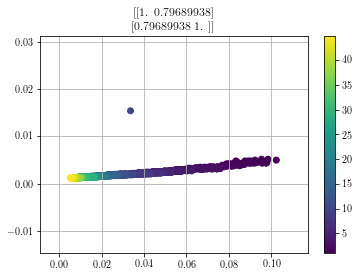

In [302]:
mask = time/86400>1
#mask = htotal>10
xvar = vz[mask,0]
#xvar = -tauy[mask]
yvar = 0.1/Htotal[mask]
#yvar = N**2*tht/(1e-4*(1+S2)) + 0*Htotal[mask]
plt.scatter(xvar, yvar, c=time[mask]/86400)
corr = np.corrcoef(xvar, yvar)
plt.title(corr**2)
plt.colorbar()
plt.grid()
#plt.ylim(-1e-2, 1e-2)

(0, 10)

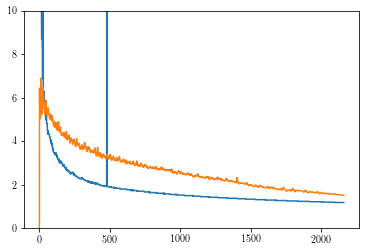

In [301]:
plt.plot(100/Htotal)
plt.plot(MOdepth)
plt.ylim(0,10)

In [237]:
VPWP.shape

(2160, 1, 256)